<a href="https://colab.research.google.com/github/MarzoliLeo/Challenge-LogoUnibo/blob/main/Challenge_LogoUnibo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Operazioni preliminari.
Unzippare i dataset zippati e importati nell'ambiente colab dal proprio file system.

In [2]:
import zipfile
import os

def extract_and_rename(zip_filename, target_directory):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(target_directory)

# Estrarre il primo file ZIP in una directory chiamata directory1
extract_and_rename('/content/task_test-set-2023_12_04_21_10_14-yolo 1.1.zip', '/content/test-set-YOLO')

# Estrarre il secondo file ZIP in una directory chiamata directory2
extract_and_rename('/content/task_training-2023_12_04_21_10_08-yolo 1.1.zip', '/content/train-set-YOLO')



# Installare KerasCV
La libreria KerasCV mette a disposizione componenti specifiche per svolgere task di Computer Vision come modelli pre-addestrati, metriche e layer.

La cella seguente permette di installare l'ultima versione di KerasCV.

In [3]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.0 MB/s eta 0:00:00


# Import delle librerie


In [5]:
import os
import tensorflow as tf
import numpy as np
import keras_cv
import cv2
import random
import math
from tensorflow import keras
from matplotlib import pyplot as plt

Using TensorFlow backend


# **Functioni di utilità per l'addestramento**
Tramite la cella sottostante è possibile definire alcune funzioni di utilità usate durante l'esercitazione:
- **plot_images_with_xywh_bounding_boxes** visualizza un *mini-batch* di immagini con le corrispondenti *bounding box*;
- **plot_images_with_y_preds** visulizza un *mini-batch* di immagini con le corrispondenti *prediction*;
- **parse_yolov8_annotation** legge da un file di testo le annotazioni di un'immagine nel formato YOLOv8;
- **load_dataset_info** carica in memoria i percorsi assoluti di tutte le immagini e le rispettive annotazioni di un dataset;
- **from_rel_xywh_to_xywh** converte le annotazioni dal formato relativo al formato assoluto date in input le dimensioni delle immagini;
- **load_dataset_element** carica in memoria un'immagine dato in input il percorso in cui è memorizzara e la associa alle corrispondenti *bounding box*;
- **prepare_dataset** prepara il dataset dato in input caricando le immangini e applicando alcune operazioni di preprocessing tra cui il ridimensionamento delle immagini alle dimensioni di input del modello;
- **plot_history** visualizza il grafico delle loss sui dataset di training e validation;
- **compute_mean_average_precision** calcola la *mean Average Precision* (mAP) date in input le *bounding box* vere e quelle predette dalla rete.

In [27]:
def plot_images_with_xywh_bounding_boxes(images, boxes, class_ids, class_labels, image_per_row=4, show_labels=True, confidences=None):
    class_colors = plt.cm.hsv(np.linspace(0, 1, len(class_labels)+1)).tolist()

    image_count = len(images)
    row_count = math.ceil(image_count/image_per_row)
    col_count = image_per_row

    _, axs = plt.subplots(nrows=row_count, ncols=col_count, figsize=(18, 4*row_count), squeeze=False)
    for r in range(row_count):
        for c in range(col_count):
            axs[r, c].axis('off')

    for i in range(image_count):
        r = i // image_per_row
        c = i % image_per_row

        image_path = train_image_path_list[i]
        axs[r, c].imshow(plt.imread(image_path))
        for box_idx in range(len(boxes[i])):
            box = boxes[i][box_idx]
            class_idx = class_ids[i][box_idx]
            color = class_colors[class_idx]
            xmin = box[0]
            ymin = box[1]
            w = box[2]
            h = box[3]
            axs[r, c].add_patch(plt.Rectangle((xmin, ymin), w, h, color=color, fill=False, linewidth=2))
            if show_labels:
                label = '{}'.format(class_labels[class_idx])
                if confidences is not None:
                    label += ' {:.2f}'.format(confidences[i][box_idx])
                axs[r, c].text(xmin, ymin, label, size='large', color='white', bbox={'facecolor': color, 'alpha': 1.0})



def plot_images_with_y_preds(images,y_preds,class_labels,image_per_row=4,show_labels=True):
  image_count=images.shape[0]
  plot_images_with_xywh_bounding_boxes(images,
                                      [y_preds['boxes'][i,:y_preds['num_detections'][i]] for i in range(image_count)],
                                      [y_preds['classes'][i,:y_preds['num_detections'][i]] for i in range(image_count)],
                                      class_labels,
                                      image_per_row=image_per_row,
                                      show_labels=show_labels,
                                      confidences=[y_preds['confidence'][i,:y_preds['num_detections'][i]] for i in range(image_count)])

def parse_yolov8_annotation(txt_file):
    yolov8_boxes = []
    class_ids = []
    with open(txt_file) as file:
      for line in file:
        splitted_line = line.split()
        class_ids.append(int(splitted_line[0]))
        rcx = float(splitted_line[1])
        rcy = float(splitted_line[2])
        rw = float(splitted_line[3])
        rh = float(splitted_line[4])
        rxmin=rcx-rw/2
        rymin=rcy-rh/2
        yolov8_boxes.append([rxmin, rymin, rw, rh]) #rel_xywh

    return yolov8_boxes, class_ids

def load_dataset_info(txt_file_list,image_path):
  image_path_list = []
  image_yolov8_box_list = []
  image_class_id_list = []
  for txt_file in txt_file_list:
      yolov8_boxes, class_ids = parse_yolov8_annotation(txt_file)
      image_path_list.append(image_path+os.path.basename(os.path.splitext(txt_file)[0])+'.png')
      image_yolov8_box_list.append(yolov8_boxes)
      image_class_id_list.append(class_ids)

  return image_path_list,image_yolov8_box_list,image_class_id_list

def from_rel_xywh_to_xywh(dataset_rel_xywh_bboxes,image_shape):
  image_height=image_shape[0]
  image_width=image_shape[1]

  dataset_xywh_bboxes=[]
  for image_bboxes in dataset_rel_xywh_bboxes:
    image_xywh_bboxes=[]
    for image_bbox in image_bboxes:
      xmin=image_bbox[0]*image_width
      ymin=image_bbox[1]*image_height
      w=image_bbox[2]*image_width
      h=image_bbox[3]*image_height
      image_xywh_bboxes.append([xmin, ymin, w, h])
    dataset_xywh_bboxes.append(image_xywh_bboxes)

  return dataset_xywh_bboxes

def load_dataset_element(image_path, bboxes,classes):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    bounding_boxes = {
        'classes': tf.cast(classes, dtype=tf.float32),
        'boxes': bboxes,
    }
    return {'images': tf.cast(image, tf.float32), 'bounding_boxes': bounding_boxes}

def prepare_dataset(dataset,batch_size,model_input_size):
  resizer = keras.Sequential(layers=[keras_cv.layers.Resizing(model_input_size,model_input_size,pad_to_aspect_ratio=True,bounding_box_format='xywh')])

  ds = dataset.map(load_dataset_element, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.shuffle(dataset.cardinality())
  ds = ds.ragged_batch(batch_size, drop_remainder=True)
  ds = ds.map(resizer, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(lambda inputs: (inputs['images'], inputs['bounding_boxes']), num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

def plot_history(history):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

def compute_mean_average_precision(y_true, y_pred):
  coco_metrics=keras_cv.metrics.BoxCOCOMetrics(bounding_box_format='xywh',evaluate_freq=1)
  coco_metrics.update_state(y_true, y_pred)
  return coco_metrics.result(force=True)['MaP'].numpy()

# Preparazione del dataset.
Ora facciamo una serie di operazioni per la preparazione del dataset.

In [51]:
# Classi del problema
unibo_class_labels = ['none','logo']

#Imposto una dimensione fissa per le immagini.
original_image_size=(512,512)

# Percorsi in cui si trovano le immagini dei set di training, validation e test
train_path_images = '/content/train-set-YOLO/images/'
val_path_images = '/content/validation-set-YOLO/images/'
test_path_images = '/content/test-set-YOLO/images/'

# Percorsi in cui si trovano le annotazioni dei set di training, validation e test
train_path_annotations = '/content/train-set-YOLO//labels/'
val_path_annotations = '/content/validation-set-YOLO/labels/'
test_path_annotations = '/content/test-set-YOLO/labels/'

# Lista dei file delle annotazioni di training
train_txt_files = sorted(
    [
        os.path.join(train_path_annotations, file_name)
        for file_name in os.listdir(train_path_annotations)
        if file_name.endswith(".txt")
    ]
)

# Lista dei file delle annotazioni di validation
val_txt_files = sorted(
    [
        os.path.join(val_path_annotations, file_name)
        for file_name in os.listdir(val_path_annotations)
        if file_name.endswith(".txt")
    ]
)

# Lista dei file delle annotazioni di test
test_txt_files = sorted(
    [
        os.path.join(test_path_annotations, file_name)
        for file_name in os.listdir(test_path_annotations)
        if file_name.endswith(".txt")
    ]
)

print('Numero dei file di training: ',len(train_txt_files))
print('Numero dei file di validation: ',len(val_txt_files))
print('Numero dei file di test: ',len(test_txt_files))


Numero dei file di training:  40
Numero dei file di validation:  10
Numero dei file di test:  10


La cella sottostante permette di caricare in memoria i percorsi assoluti delle immagini e le rispettive annotazioni per i set di training, validation e test.

*   ..._image_path_list = è la lista con i percorsi assoluti delle immagini.
*   ..._yolov8_box_list = è la lista con le dimensioni dei box per la detection.
*   ..._class_id_list = è la lista con la classificiazione (none, logo)



In [52]:
train_image_path_list, train_yolov8_box_list, train_image_class_id_list = load_dataset_info(train_txt_files, train_path_images)
val_image_path_list, val_yolov8_box_list, val_image_class_id_list = load_dataset_info(val_txt_files, val_path_images)
test_image_path_list, test_yolov8_box_list, test_image_class_id_list = load_dataset_info(test_txt_files, test_path_images)

Il formato YOLOv8 con cui sono memorizzate le bounding box dei pezzi degli scacchi riporta  x ,  y ,  w  e  h  come valori relativi (nell'intervallo  [0;1] ) rispetto alla dimensione dell'immagine a cui sono associate.

La cella sottostante stampa a video i valori  (x,y,w,h)  in formato relativo della bounding box associata alla prima immagine del training set.

In [53]:
print(train_yolov8_box_list[0])

[[0.265039, 0.4981835, 0.430566, 0.425527]]


Ai fini dell'addestramento del modello e della visualizzazione dei risultati è conveniente convertire le *bounding box*  da valori relativi a valori assoluti nel formato **'xywh'**. Per fare ciò è sufficiente utilizzare la funzione di utilità **from_rel_xywh_to_xywh** passandogli in input, oltre alle *bounding box* nel formato YOLOv8, le dimensioni delle immagini del dataset ($512\times512$).

In [54]:
train_xywh_box_list = from_rel_xywh_to_xywh(train_yolov8_box_list,original_image_size)
val_xywh_box_list = from_rel_xywh_to_xywh(val_yolov8_box_list,original_image_size)
test_xywh_box_list = from_rel_xywh_to_xywh(test_yolov8_box_list,original_image_size)

La cella sottostante stampa a video i valori $(x,y,w,h)$ in formato assoluto della *bounding box* associata alla prima immagine del training set.

In [55]:
print(train_xywh_box_list[0])

[[135.699968, 255.069952, 220.449792, 217.869824]]


# Visualizzazione preliminari dei dati, non ancora lavorati.
Effetuiamo questa lavorazione per mostrare la difficoltà del problema di classificazione.

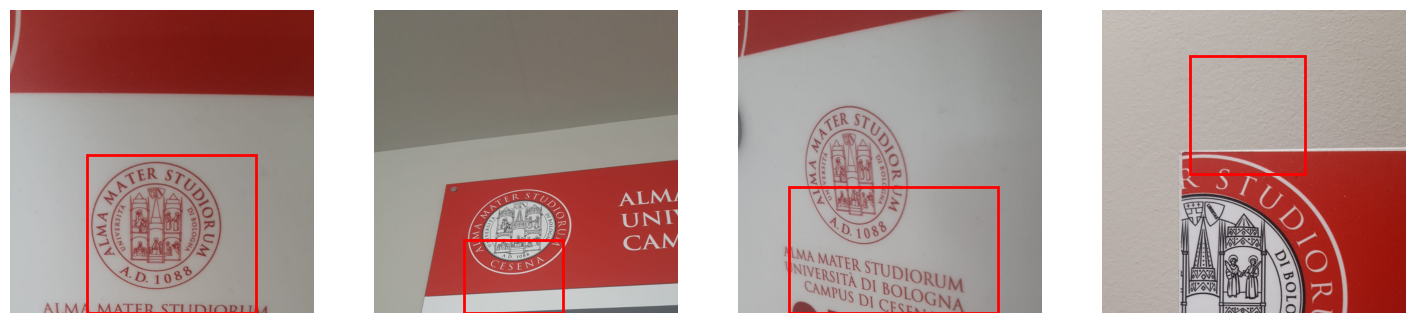

In [56]:
image_count=4
random_idx=random.randint(0,len(train_image_path_list)-image_count)

plot_images_with_xywh_bounding_boxes([plt.imread(train_image_path_list[i]) for i in range(random_idx,random_idx+image_count)],
                                     train_xywh_box_list[random_idx:random_idx+image_count],
                                     train_image_class_id_list[random_idx:random_idx+image_count],
                                     unibo_class_labels,
                                     image_per_row=4,
                                     show_labels=False)

## **Preparazione dei dati**
Quando si usano database di grosse dimensioni non sempre è possibile e conveniente caricarli interamente in memoria. Per ovviare a questo problema è possibile utilizzare la classe [**Dataset**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) di TensorFlow che permette di gestire in maniera efficiente i dati caricandoli in memoria solo all'occorrenza.

Il metodo [**from_tensor_slices**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) crea un'istanza della classe **Dataset** partendo da un insieme di tensori che posseggono la prima dimensione con la medesima cardinalità.

Avendo memorizzato le informazioni dei set di training, validation e test in delle liste, prima di tutto dobbiamo convertirle in tensori. Le funzioni [**tf.constant**](https://www.tensorflow.org/api_docs/python/tf/constant) e  [**tf.ragged.constant**](https://www.tensorflow.org/api_docs/python/tf/ragged/constant) di TensorFlow creano rispettivamente un tensore e un tensore irregolare (ovvero che può avere delle dimensioni a lunghezza variabile) a partire da una lista. I tensori irregolari sono necessari in quanto il numero di *bounding box* può variare per ogni immagine.

In [57]:
logo_train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_image_path_list),
                                                      tf.ragged.constant(train_xywh_box_list),
                                                      tf.ragged.constant(train_image_class_id_list)))

logo_val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_image_path_list),
                                                     tf.ragged.constant(val_xywh_box_list),
                                                     tf.ragged.constant(val_image_class_id_list)))

logo_test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_image_path_list),
                                                     tf.ragged.constant(test_xywh_box_list),
                                                     tf.ragged.constant(test_image_class_id_list)))

La funzione **prepare_dataset** permette di preparare i dataset prima di utilizzarli nelle fasi di addestramento e valutazione delle prestazioni.

**Iperparametri:**

*   batch_size => dimensione della suddivisione dei set.
*   model_input_size => è la dimensione dell'immagine che deve essere superiore o uguale a quella delle immaggini nei set. (in questo caso uguale e quindi 512)



In [58]:
batch_size = 2

model_input_size = 512

logo_train_ds = prepare_dataset(logo_train_data,
                                 batch_size,
                                 model_input_size)

logo_val_ds = prepare_dataset(logo_val_data,
                               batch_size,
                               model_input_size)

logo_test_ds = prepare_dataset(logo_test_data,
                                logo_test_data.cardinality().numpy(),
                                model_input_size)

La cella sottostante riporta il numero di *mini-batch* creati per ognuno dei tre dataset.

In [59]:
print('Mini-batch di training: ', logo_train_ds.cardinality().numpy())
print('Mini-batch di validation: ', logo_val_ds.cardinality().numpy())
print('Mini-batch di test: ', logo_test_ds.cardinality().numpy())

Mini-batch di training:  20
Mini-batch di validation:  5
Mini-batch di test:  1


Iterando su un Dataset è possibile ottenere un *mini-batch* per volta.

**Otterrai**:

* Stampa la forma (dimensioni) del tensore images. Questo fornisce le dimensioni del mini-batch di immagini, dove il primo elemento di shape rappresenta il numero di immagini nel mini-batch, e gli altri elementi rappresentano le dimensioni dell'immagine (altezza, larghezza, canali).
* Stampa la forma del tensore bounding_boxes['boxes'], che rappresenta le coordinate delle bounding box. Di solito, avrai 4 colonne per le coordinate (xmin, ymin, larghezza, altezza), e il numero di righe corrisponderà al numero di bounding box nel mini-batch.
* Stampa la forma del tensore bounding_boxes['classes'], che rappresenta le classi associate alle bounding box. Il numero di righe di questo tensore corrisponderà al numero di bounding box nel mini-batch.



In [60]:
images, bounding_boxes = next(iter(logo_train_ds))

print('Shape del mini-batch delle immagini: ', images.shape)
print('Shape del mini-batch delle bounding box: ', bounding_boxes['boxes'].shape)
print('Shape del mini-batch delle classi associate alle bounding box: ', bounding_boxes['classes'].shape)

Shape del mini-batch delle immagini:  (2, 512, 512, 3)
Shape del mini-batch delle bounding box:  (2, None, 4)
Shape del mini-batch delle classi associate alle bounding box:  (2, None)


Grazie alla funzione **plot_images_with_xywh_bounding_boxes** è possibile visualizzare a video le immagini appartenenti a un *mini-batch* con evidenziate le *bounding box* associate.

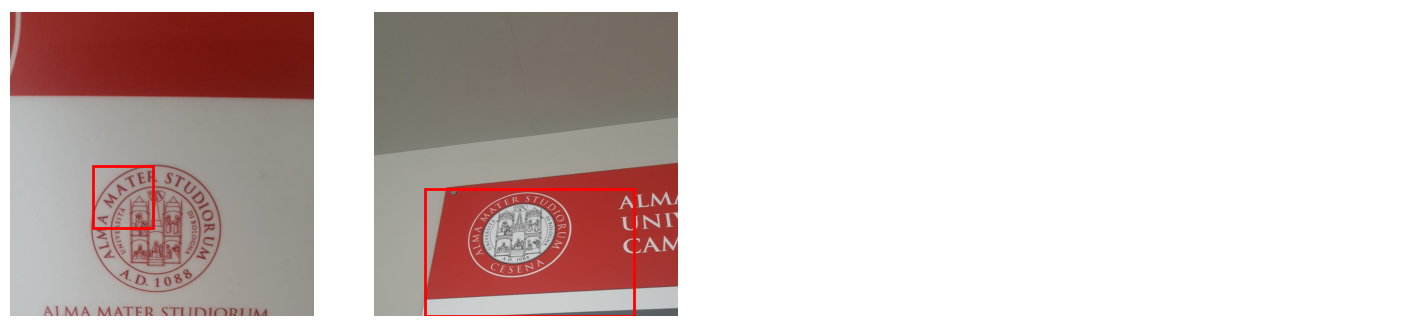

In [61]:
plot_images_with_xywh_bounding_boxes(images/255,
                                     bounding_boxes['boxes'].to_list(),
                                     tf.dtypes.cast(bounding_boxes['classes'],tf.int32).to_list(),
                                     unibo_class_labels,
                                     image_per_row=4,
                                     show_labels=False)

#**YOLOv8**
YOLOv8 è l'ultimo modello basato sull'architettura YOLO (*You Only Look Once*) in grado di individuare in tempo reale oggetti multipli all'interno di un'immagine con un elevato livello di accuratezza. Quest'ultima versione è in grado di supportare diversi tipi di *task* tra cui: *detection*, segmentazione e classificazione.

# Transfer Learning
Viste le notevoli quantità di dati che servono per addestrare un modello YOLOv8, utilizziamo un modello già addestrato da adattare al nostro problema.

## Caricamento del modello pre-addestrato
Il metodo [**from_preset**](https://keras.io/api/keras_cv/models/backbones/yolo_v8/#frompreset-method) della classe [**YOLOV8Backbone**](https://keras.io/api/keras_cv/models/backbones/yolo_v8/#yolov8backbone-class) permette di istanziare una YOLOv8 caricando i pesi pre-addestrati su uno specifico dataset per poi utilizzarli in un altro contesto o su un altro *task*.

Eseguendo la cella sottostante verranno caricati i pesi ottenuti utilizzando in fase di addestramento il daset [**COCO**](https://cocodataset.org/) (Avremmo potuto usare un qualsiasi altro dataset, ma questo ci torna utile).

In [62]:
yolov8_backbone = keras_cv.models.YOLOV8Backbone.from_preset('yolo_v8_s_backbone_coco', load_weights=True)

20596968/20596968 [==============================] - 0s 0us/step


## **Creazione del modello**
Il codice seguente crea un'istanza della classe **YOLOV8Detector** utilizzando il *backbone* con i pesi pre-addestrati caricati nella cella precedente e impostando il numero di classi (*num_classes*) in base al problema che vogliamo affrontare.

In [72]:
yolov8_logo_detector = keras_cv.models.YOLOV8Detector(backbone=yolov8_backbone,
                                                       num_classes=len(unibo_class_labels),
                                                       bounding_box_format='xywh')

## **Visualizzazione del modello**
Eseguendo la cella seguente è possibile stampare un riepilogo testuale della struttura del modello appena caricato.

In [73]:
yolov8_logo_detector.summary()

Model: "yolov8_detector_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_1 (Functional)        {'P3': (None, None, None,    5089760   ['input_3[0][0]']             
                             128),                                                                
                              'P4': (None, None, None,                                            
                             256),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                

Se si preferisce una visualizzazione grafica, eseguire la cella seguente.

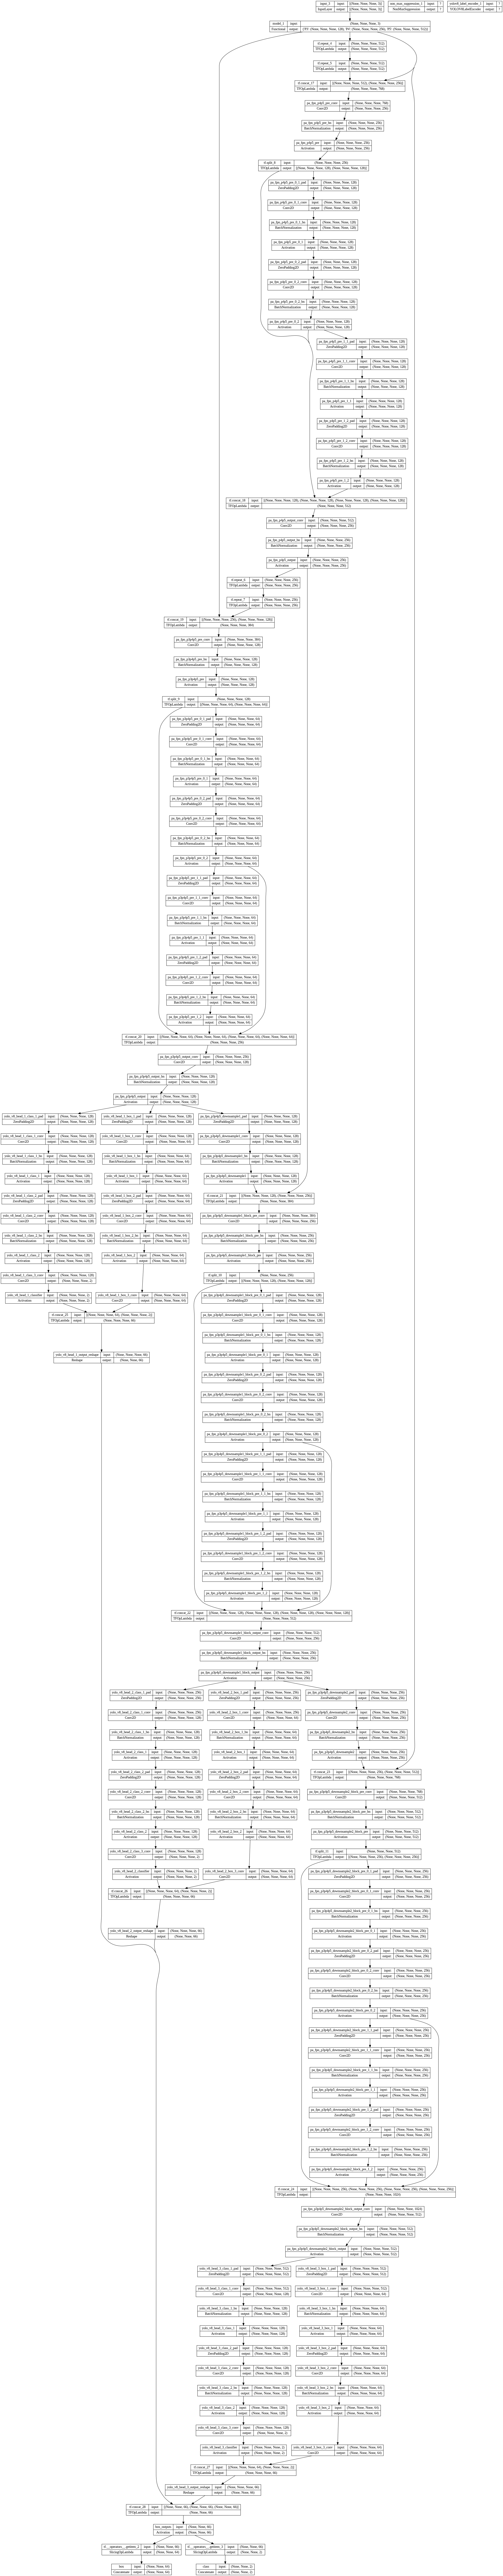

In [74]:
tf.keras.utils.plot_model(yolov8_logo_detector, show_shapes=True, show_layer_names=True)

## **Configurare il modello per il training**
Con il metodo **compile** è possibile configurare il modello per la fase di training dati in input:
- un ottimizzatore (*optimizer*);
- la *loss* di classificazione (*classification_loss*);
- la *loss* di regressione delle *bounding box* (*box_loss*).

In particolare come *loss* di regressione delle *bounding box* viene utilizzata la **'ciou'** (*Complete Intersection over Union*), una variante della *Intersection over Union* (IoU).

In [75]:
# Configura il modello per il training
yolov8_logo_detector.compile(optimizer='adam', classification_loss='binary_crossentropy', box_loss='ciou')

# **Training**
Ora siamo pronti per effettuare il *fine-tuning* della YOLOv8 utilizzando le immagini e le annotazioni dei dataset di training (*chess_train_ds*) e validation (*chess_val_ds*) per un numero di epoche pari a *epoch_count*.

In [77]:
# Numero di epoche di addestramento
epoch_count = 30

Per evitare che il modello faccia *overfitting* sul dataset di training, si può utilizzare la classe di *callback* [**EarlyStopping**](https://keras.io/api/callbacks/early_stopping/#earlystopping-class) che permette di interrompere l'addestramento quando la metrica monitorata smette di migliorare. I parametri da impostare sono:
- *monitor* la metrica da monitoriare;
- *patience* il numero di epoche consecutive in cui la metrica monitorata non migliora da attendere prima di interrompere l'addestramento;
- *restore_best_weights* permette di reimpostare i pesi all'epoca in la metrica monitorata ha ottenuto il valore migliore.

In [76]:
patience = 5
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

Nella cella seguente viene richiamato il metodo [**fit**](https://keras.io/api/models/model_training_apis/#fit-method) che esegue l'intera fase di addestramento in maniera automatica monitorando costantemente la *loss function* su training e validation set.

In [78]:
history = yolov8_logo_detector.fit(logo_train_ds,
                                    validation_data = logo_val_ds,
                                    epochs=epoch_count,
                                    callbacks=[early_stop])

Epoch 1/30
20/20 [==============================] - 130s 5s/step - loss: 360.0064 - box_loss: 2.5018 - class_loss: 357.5046 - val_loss: 953.4360 - val_box_loss: 2.6392 - val_class_loss: 950.7969
Epoch 2/30
20/20 [==============================] - 82s 4s/step - loss: 147.0955 - box_loss: 2.2117 - class_loss: 144.8838 - val_loss: 223.6220 - val_box_loss: 0.0000e+00 - val_class_loss: 223.6220
Epoch 3/30
20/20 [==============================] - 81s 4s/step - loss: 107.7590 - box_loss: 2.2854 - class_loss: 105.4736 - val_loss: 327.2789 - val_box_loss: 2.6305 - val_class_loss: 324.6485
Epoch 4/30
20/20 [==============================] - 86s 4s/step - loss: 68.3346 - box_loss: 2.1529 - class_loss: 66.1817 - val_loss: 43.8411 - val_box_loss: 2.5727 - val_class_loss: 41.2684
Epoch 5/30
20/20 [==============================] - 86s 4s/step - loss: 50.1645 - box_loss: 2.2358 - class_loss: 47.9287 - val_loss: 50.1260 - val_box_loss: 2.8870 - val_class_loss: 47.2390
Epoch 6/30
20/20 [===============

Il metodo **fit** restituisce un oggetto (*history*) che contiene per ogni epoca i valori della *loss function* sia per il training sia per il validation set.

Richiamando la funzione **plot_history** è possibile graficare tali valori.

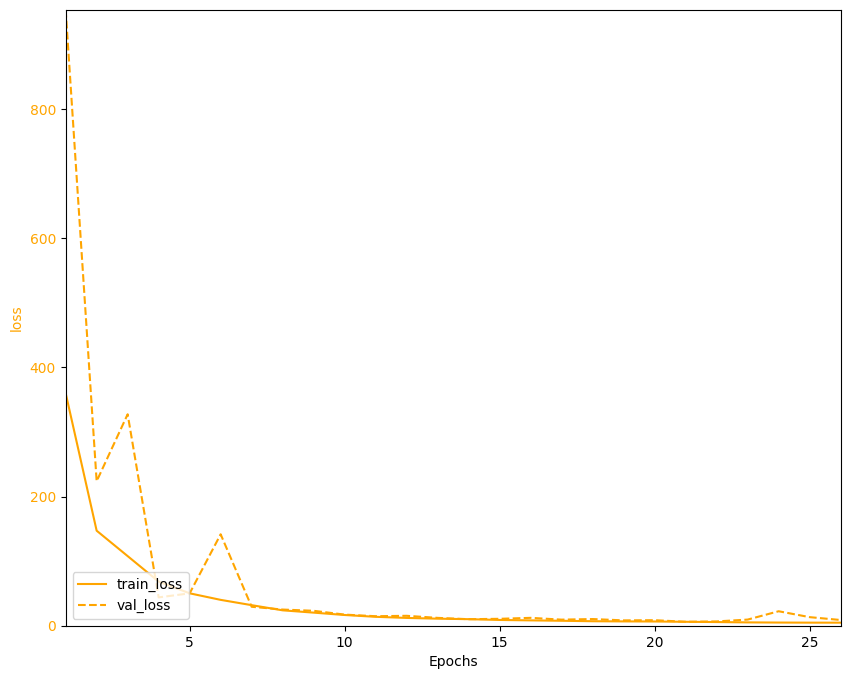

In [79]:
plot_history(history)

# **Verifica sul test set.**
Per verificare l'effettiva capacità di generalizzazione del modello appena addestrato, è fondamentale misurarne le prestazioni sul dataset di test.

## **Test set**
Iterando sul dataset di test (*logo_test_ds*) è possibile estrarre immagini (*test_x*) e annotazioni (*test_y_true*).

In [80]:
test_x, test_y_true = next(iter(logo_test_ds.take(1)))
print('Shape del mini-batch di test: ',test_x.shape)

Shape del mini-batch di test:  (10, 512, 512, 3)


## **Object detection**
Eseguendo la cella sottostante, si effettuerà la *detection* sulle immagini del test set (*test_x*) richiamando il metodo **predict** del modello appena addestrato.

In [84]:
test_y_pred = yolov8_logo_detector.predict(test_x)

1/1 [==============================] - 7s 7s/step


## **Visualizzazione dei risultati**
Richiamando la funzione di utilità **plot_images_with_y_preds** è possibile visualizzare i pezzi trovati sulle immagini del test set.

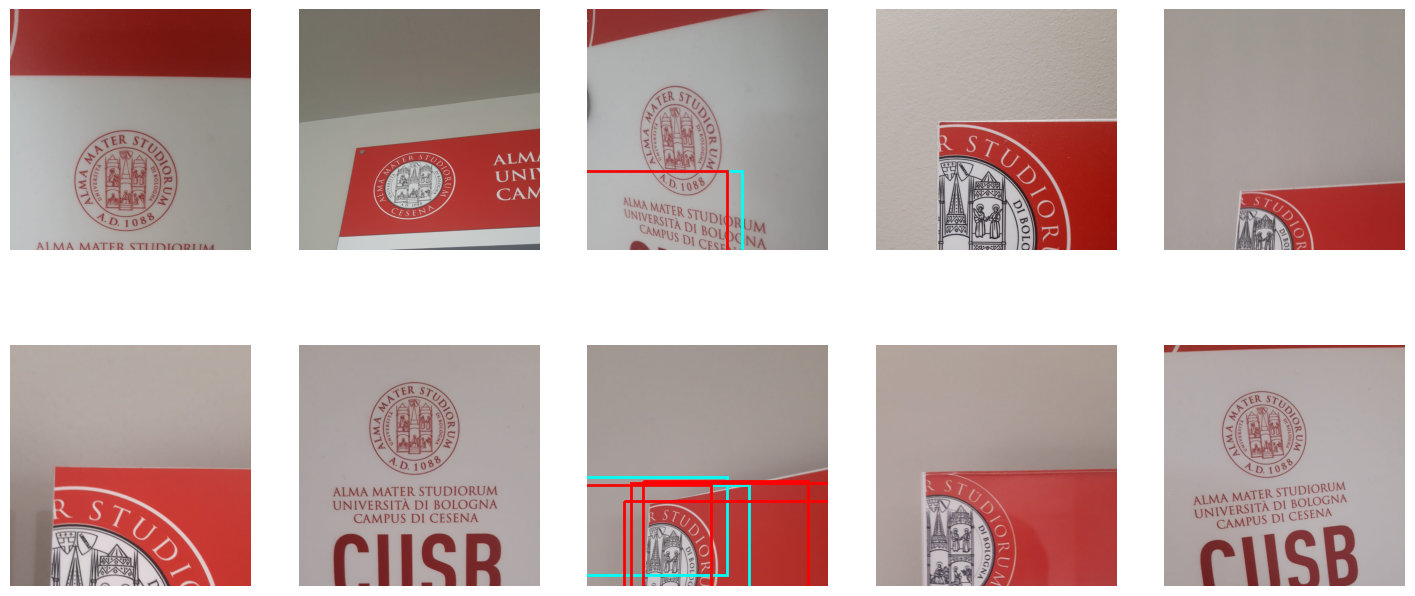

In [86]:
plot_images_with_y_preds(test_x/255, test_y_pred, unibo_class_labels, image_per_row=5, show_labels=False)

Visivamente si possono notare gli ottimi risultati ottenuti.

Per avere una valutazione delle prestazioni più obiettiva è opportuno calcolare la *mean Average Precision* (mAP).

Per farlo è sufficiente richiamare la funzione **compute_mean_average_precision** passandogli in input il *ground truth* del test set e le *prediction* (*test_y_pred*) restituite dal modello.

In [87]:
test_map=compute_mean_average_precision(test_y_true, test_y_pred)
print(test_map)

0.06059406


L'mAP ottenuto risulta molto elevato confermando le ottime prestazioni della YOLOv8 nell'individuare correttamente i pezzi degli scacchi.